In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

# 1.Data

In [2]:
child = pd.read_csv(r"child data.csv")
#first few rows
child.head()

,LN,UF1,UF2,UF4,UF5,UF7Y,UF10,UF17,UB2,UB6,...,UCF2,UCF3,UCF4,UCF7,UCF11,chweight,caretakerdis,cdisability,mlevel,UCD2B
0,2,1,18,1,207,2017,1,1,11,1,...,2,2,2,1,2,4.92,2,2,0,2
1,3,1,9,2,203,2017,1,1,4,1,...,2,2,2,1,2,1.68,2,2,2,2
2,3,1,11,2,207,2017,1,1,12,1,...,2,2,2,1,2,3.28,2,1,1,2
3,3,1,14,2,203,2017,2,3,2,3,...,2,2,2,2,3,0.00,7,2,0,1
4,4,1,7,2,207,2017,1,1,12,1,...,2,2,2,1,3,1.64,7,2,1,2


## 1.1. Data overview

In [3]:
print ("Rows     : " ,child.shape[0])
print ("Columns  : " ,child.shape[1])
print ("\nFeatures : \n" ,child.columns.tolist())
print ("\nMissing values :  ", child.isnull().sum().values.sum())
print ("\nUnique values :  \n",child.nunique())

Rows     :  62514
Columns  :  31

Features : 
 ['LN', 'UF1', 'UF2', 'UF4', 'UF5', 'UF7Y', 'UF10', 'UF17', 'UB2', 'UB6', 'UCD2A', 'UCD2C', 'UCD2D', 'UCD2E', 'UCD2F', 'UCD2G', 'UCD2H', 'UCD2I', 'UCD2J', 'UCD2K', 'UCD5', 'UCF2', 'UCF3', 'UCF4', 'UCF7', 'UCF11', 'chweight', 'caretakerdis', 'cdisability', 'mlevel', 'UCD2B']

Missing values :   0

Unique values :  
 LN                39
UF1             2692
UF2               20
UF4               37
UF5              341
UF7Y               2
UF10               2
UF17               7
UB2               24
UB6                6
UCD2A              6
UCD2C              5
UCD2D              5
UCD2E              6
UCD2F              6
UCD2G              4
UCD2H              6
UCD2I              6
UCD2J              6
UCD2K              4
UCD5               7
UCF2               4
UCF3               4
UCF4               4
UCF7               6
UCF11             13
chweight         931
caretakerdis       3
cdisability        3
mlevel             7
UCD2B  

# 2. Data Manipulation

In [9]:
#Data Manipulation

#Replacing spaces with null values in UF5 column
child['UF5'] = child["UF5"].replace(" ",np.nan)

# #Dropping null values from total charges column which contain .15% missing data 
# child= child[child["UFINT"].notnull()]
# child = child.reset_index()[child.columns]



#replace values
child["UCD2B"] = child["UCD2B"].replace({1:"Abnormal Behavior",2:"Nomal Bahavior"})




#Separating Normal and abnormal customers
Abnormal     = child[child["UCD2B"] == "Abnormal Behavior"]
Normal = child[child["UCD2B"] == "Normal Behavior"]

#Separating catagorical and numerical columns
Id_col     = ['UF1']
target_col = ["UCD2B"]
cat_cols   = child.nunique()[child.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in child.columns if x not in cat_cols + target_col + Id_col]

# 4. Data preprocessing

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['UF1']
#Target columns
target_col = ["UCD2B"]
#categorical columns
cat_cols   = child.nunique()[child.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in child.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = child.nunique()[child.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    child[i] = le.fit_transform(child[i])
    
#Duplicating columns for multi value columns
child = pd.get_dummies(data = child,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(child[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_child_og = child.copy()
child = child.drop(columns = num_cols,axis = 1)
child = child.merge(scaled,left_index=True,right_index=True,how = "left")

# 5. Model Building
### 5.1. Baseline Model


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

In [13]:
#splitting train and test data 
train,test = train_test_split(child,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in child.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]


In [14]:
#threshold_plot - if True returns threshold plot for model
    
def child_behavior_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Abnormal","Normal"],
                        y = ["Abnormal","Normal"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.69      0.64      0.66      2348
           1       0.80      0.83      0.81      4018

    accuracy                           0.76      6366
   macro avg       0.74      0.73      0.74      6366
weighted avg       0.76      0.76      0.76      6366

Accuracy   Score :  0.7588752748978951
Area under curve :  0.7332224326137152 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



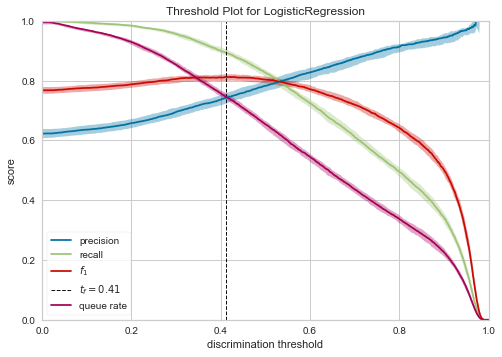

In [14]:
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
child_behavior_prediction(logit,train_X,test_X,
                             train_Y,test_Y,cols,"coefficients",threshold_plot = True)

In [15]:
#threshold_plot - if True returns threshold plot for model
def child_behavior_prediction_alg(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Abnormal","Normal"],
                        y = ["Abnormal","Normal"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic'
                                            ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
child_behavior_prediction_alg(knn,train_X,test_X,
                             train_Y,test_Y,threshold_plot = True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=11, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

           0       0.66      0.41      0.51      2348
           1       0.72      0.87      0.79      4018

    accuracy                           0.70      6366
   macro avg       0.69      0.64      0.65      6366
weighted avg       0.70      0.70      0.68      6366

Accuracy   Score :  0.7037386113729186
Area under curve :  0.6431662289713326 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### 5.2. Synthetic Minority Oversampling TEchnique (SMOTE)
* Randomly pick a point from the minority class.
* Compute the k-nearest neighbors (for some pre-specified k) for this point.
* Add k new points somewhere between the chosen point and each of its neighbors

In [16]:
from imblearn.over_sampling import SMOTE

cols    = [i for i in child.columns if i not in Id_col+target_col]

smote_X = child[cols]
smote_Y = child[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)
#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X ,os_smote_Y = os.fit_sample(smote_train_X ,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X ,columns =cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y ,columns =target_col)

In [17]:
logit_smote  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
knn_1 = KNeighborsClassifier(n_neighbors = 9 , metric = 'minkowski' ,p = 1) #my previous classifier parameters

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=1,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

           0       0.60      0.67      0.64      2348
           1       0.79      0.74      0.77      4018

    accuracy                           0.72      6366
   macro avg       0.70      0.71      0.70      6366
weighted avg       0.72      0.72      0.72      6366

Accuracy   Score :  0.7159912032673579
Area under curve :  0.7066849093898582 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



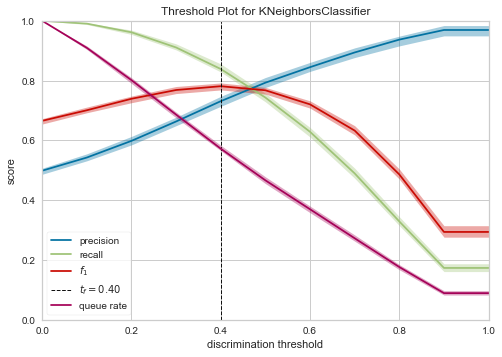

In [19]:
child_behavior_prediction_alg(knn_1,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.60      0.77      0.68      2348
           1       0.84      0.71      0.77      4018

    accuracy                           0.73      6366
   macro avg       0.72      0.74      0.72      6366
weighted avg       0.75      0.73      0.73      6366

Accuracy   Score :  0.7288721332076658
Area under curve :  0.7373341471046388 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



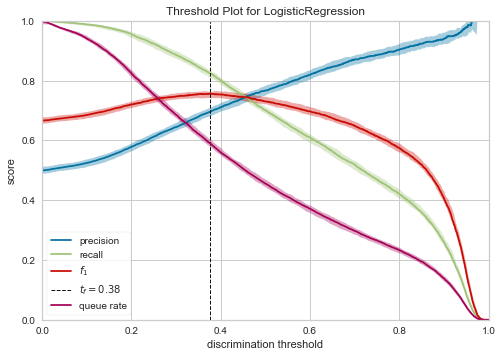

In [20]:
child_behavior_prediction_alg(logit_smote,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=11, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

           0       0.48      0.84      0.61      2348
           1       0.83      0.46      0.59      4018

    accuracy                           0.60      6366
   macro avg       0.66      0.65      0.60      6366
weighted avg       0.70      0.60      0.60      6366

Accuracy   Score :  0.6010053408733899
Area under curve :  0.6511746968284965 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



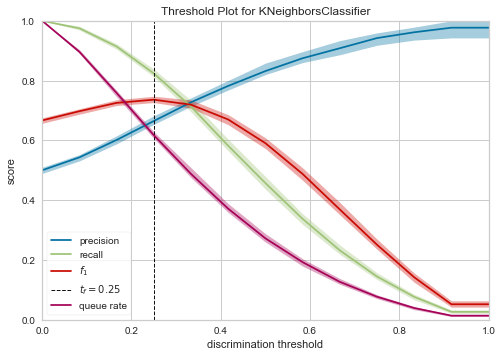

In [21]:
child_behavior_prediction_alg(knn,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

### 5.3. Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [22]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
dtc  =  RandomForestClassifier(n_jobs=2 ,random_state=0)
                                          

rfe = RFE(dtc,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_


array([114,  54,  14, 152,  87,  76, 101,  83,  85,  82, 100, 117, 126,
       131, 121, 164,  94,  92, 102, 138, 170, 124,  99, 109, 182, 123,
        86,  93, 150, 174, 151,   1,   2, 139, 147, 144,  19,   4, 172,
       149, 136,  24,  11, 179, 176, 133,   1,  10, 146, 158, 148,  44,
        49, 171, 162, 103, 108, 155, 173, 175,  68,  81, 165, 154, 140,
        37,  36, 156, 159, 167,  80,  72, 141, 178, 118, 107, 145, 163,
       134, 130, 157, 177, 132, 128, 161, 137, 127, 125, 168, 160, 142,
        91,  96, 129, 143, 135, 113, 110, 153, 181, 105,  95, 169, 104,
        90,  84,  97, 115, 106, 166, 122,  67,  46,  40,  63, 111, 180,
        22,  15,  29,   1,  38,   1,  17,  12,  23,  20,   3,  26,   1,
        52,  69,   1,   7,  18,  48,  64,  27,  89,  53,  65,  79,  70,
        57,  45,  50,  55,  59,  61,  75,  71,  73,  51,  56, 116, 112,
        34,  39, 119, 120,  88,  77,  98,  28,  78,  66,  35,  41,  42,
        47,   1,   9,  16,  60,  31,   1,   8,   1,  62,   6,  3

In [23]:
#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in child.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,})

In [24]:
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()

In [25]:
#separating train and test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      2348
           1       0.86      0.86      0.86      4018

    accuracy                           0.82      6366
   macro avg       0.81      0.81      0.81      6366
weighted avg       0.82      0.82      0.82      6366

Accuracy   Score :  0.8224945020420986
Area under curve :  0.8091107054031984 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



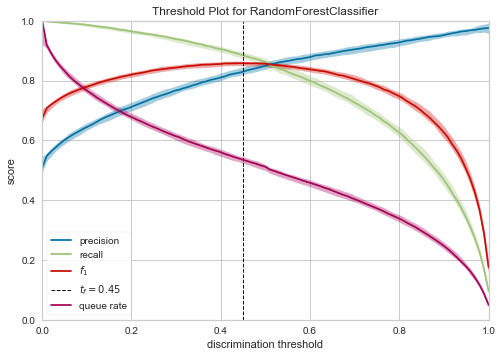

In [26]:
#applying model
child_behavior_prediction_alg(dtc,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.56      0.76      0.64      2348
           1       0.82      0.65      0.73      4018

    accuracy                           0.69      6366
   macro avg       0.69      0.70      0.69      6366
weighted avg       0.73      0.69      0.70      6366

Accuracy   Score :  0.6903864278982093
Area under curve :  0.7049876916736694 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



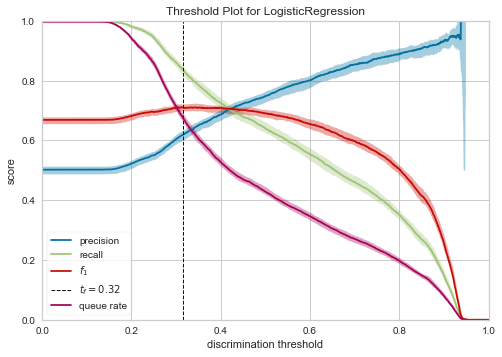

In [27]:
knn_rfe = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
logit_rfe  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
child_behavior_prediction_alg(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         threshold_plot = True)

### 5.5. Univariate Selection
* Feature extraction with univariate Statistica Test (Ch-squared for classification)
* uses the chi^2 statistical test for non negative features to select the best features.

In [1]:
from sklearn.feature_selection import chi2

In [2]:
from sklearn.feature_selection import SelectKBest

In [30]:
#select columns 
cols=[i for i in child.columns if i not in Id_col + target_col]

In [31]:
#dataframe with non negative values
df_x=df_child_og[cols]
df_y=df_child_og[target_col]

In [32]:
#fit model with k=3
select =SelectKBest(score_func =chi2,k =3)
fit   =select.fit(df_x,df_y)

In [33]:
#summerize scores 
print("scores")
print(fit.scores_)
print("p-values")
print(fit.pvalues_)

scores
[2.81341103e+00 6.48782790e+02 1.07521025e+03 2.93610655e-04
 2.33243272e+00 1.86842238e-02 1.29020646e+01 6.33993907e+00
 4.04130532e-03 3.33898008e+00 1.39486885e+00 2.21465442e+01
 4.50983840e+00 3.18432504e+01 8.31572244e-01 2.97135699e+01
 2.91114949e+02 2.60281440e+01 1.76640326e+02 4.83977961e+01
 1.29492784e+01 2.66778108e+00 1.01913218e+00 9.53214198e+00
 1.81232281e+00 3.67958313e+01 2.32835303e+01 1.40487757e+02
 7.38793123e+00 1.06288771e+00 1.15776510e-02 2.44609846e+03
 1.29713943e+03 1.30478683e+02 2.06370218e+00 2.01166541e+01
 7.81118854e+02 1.17045905e+03 3.73187075e+01 2.52755847e-01
 2.53648986e+01 5.34997781e+02 1.27736275e+03 1.82086766e+01
 1.33588388e+00 2.36237443e-02 1.20010760e+03 7.68367802e+02
 8.36608225e+01 4.58954665e-01 4.36901129e+00 3.25586166e+02
 1.98307878e+02 9.08412835e+01 1.45071164e+00 4.34585192e+01
 1.67036625e+00 5.48173656e+01 2.11810267e-02 3.39996948e+00
 2.36403516e+02 8.44144589e+01 1.11851913e+02 5.41434798e-03
 1.26462179e+01 3

In [34]:
#create dataframe
score=pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_})
score=score.sort_values(by="scores",ascending =False)
#creating new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical" ,"Categorical")

In [35]:
#plot

In [36]:
trace = go.Scatter(x = score[score["feature_type"]=="Categorical"]["features"],
                  y = score[score["feature_type"]=="Categorical"]["scores"],name = "Categorical",mode= "lines + markers",
                           marker = dict(color= 'red' ,
                                         line = dict(width = 1)))
trace1 = go.Bar(x = score[score["feature_type"]=="Numerical"]["features"],
                  y = score[score["feature_type"]=="Numerical"]["scores"],name = "Numerical",
                           marker = dict(color= 'royalblue' ,
                                         line = dict(width = 1)),
               xaxis = "x2",yaxis = "y2")
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features" ,
                      plot_bgcolor = 
                        "rgb(243 ,243 ,243 ,243)", 
                        
                        paper_bgcolor = 
                        "rgb(243 ,243 ,243 ,243)" ,
                        xaxis = dict(gridcolor = 'rgb(255 ,255 ,255)' ,
                                    tickfont = dict(size = 10) ,
                                     domain = [0,0.7],
                                     tickangle = 5 ,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255,255,255)',
                                     title = "scores" ,
                                     zerolinewidth = 1 ,ticklen=5 ,gridwidth = 2),
                        margin = dict(b= 200),
                        xaxis2 = dict(domain= [0.8 ,1] ,tickangle = 90,
                                      gridcolor = 'rgb(255,255,255)')
                       )
                  )
data = [trace ,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### 5.5. Decision Tree Visualization¶
* Using top three numerical features

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG ,display

In [38]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [39]:
#top 3 categorical features 

In [40]:
features_cat = score[score["feature_type"]=="Categorical"]["features"][:3].tolist()

In [41]:
#top 3 Numerical features 

In [42]:
features_num = score[score["feature_type"]=="Numrical"]["features"][:3].tolist()

In [43]:
#Function Attributes
#columns -selected columns
#maximum_depth -depth of tree 
#criterion_type - ["best" or "random"]
#Model Performance -True(gives model output)

In [44]:
def plot_decision_tree(columns ,maximum_depth ,criterion_type ,split_type ,model_performance =None):
    
    #separating dependent and independent variables
    dtc_x =df_x[columns]
    dtc_y = df_y[target_col]
    
    #model
    dt_classifier = DecisionTreeClassifier(max_depth = maximum_depth ,splitter = split_type ,criterion = criterion_type,)
    dt_classifier.fit(dtc_x ,dtc_y)
    #plot decision tree
    graph = Source(tree.export_graphviz(dt_classifier ,out_file = None ,
                                       rounded  = True ,proportion = False ,feature_names = columns ,
                                       precision = 2 ,class_names =["Normal" ,"Abnormal"],
                                        filled = True))
    #Model Performance
    if model_performance==True:
        child_behavior_prediction_alg(dt_classifier,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         threshold_plot = True)
        display(graph)
    plot_decision_tree(features_num ,3 ,"gini" ,"best")

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

           0       0.57      0.72      0.64      2348
           1       0.81      0.69      0.74      4018

    accuracy                           0.70      6366
   macro avg       0.69      0.71      0.69      6366
weighted avg       0.72      0.70      0.71      6366

Accuracy   Score :  0.7004398366321081
Area under curve :  0.7054287435670656 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



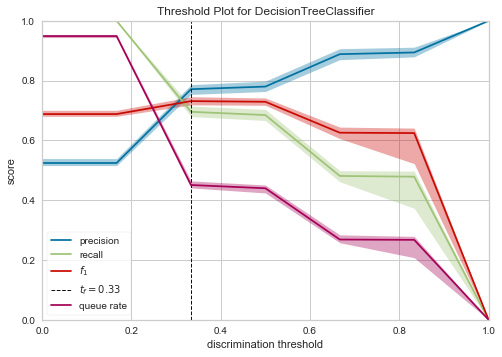

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

ValueError: at least one array or dtype is required

In [45]:
plot_decision_tree(features_cat ,3 ,"entropy" ,"best" ,model_performance = True ,)

In [46]:
#using top three classiifier

In [47]:
###columns = ['UCD2A', 'UCD2C', 'UCD2D', 'UCD2E', 'UCD2F']
####plot_decision_tree(columns ,3 ,"gini" ,"best" ,model_performance = True)

### 5.7 Visaulising a decision tree from random forest classifier

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.44      0.55      2348
           1       0.73      0.90      0.81      4018

    accuracy                           0.73      6366
   macro avg       0.73      0.67      0.68      6366
weighted avg       0.73      0.73      0.71      6366

Accuracy   Score :  0.7331134150172793
Area under curve :  0.6724550001992736 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



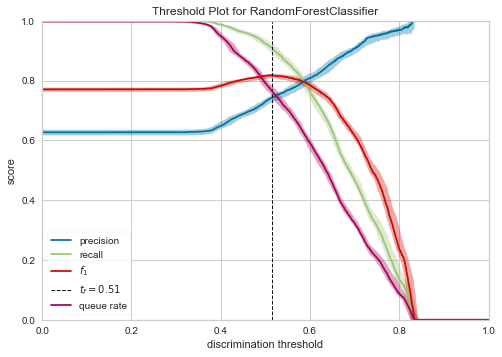

In [49]:
from sklearn.ensemble import RandomForestClassifier

#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns,nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_child_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = columns, 
                            precision  = 2,
                            class_names=["Normal","Abnormal"],
                            filled = True))
    display(graph)
    
    #model performance
    if model_performance == True :
        child_behavior_prediction_alg(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

### 5.9. Gaussian Naive Bayes.

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

           0       0.70      0.17      0.27      2348
           1       0.66      0.96      0.78      4018

    accuracy                           0.67      6366
   macro avg       0.68      0.56      0.53      6366
weighted avg       0.68      0.67      0.60      6366

Accuracy   Score :  0.6668237511781339
Area under curve :  0.5638277665327152 



C:\Minnicinda\envs\tensorflow\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



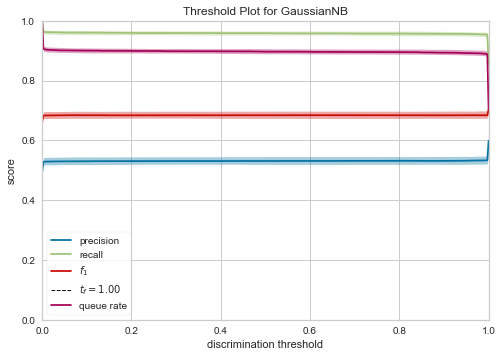

In [50]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
child_behavior_prediction_alg(gnb,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

### 5.10. Support Vector Machine
“Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space .where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes

In [ ]:
from sklearn.svm import SVC

#Support vector classifier
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

cols = [i for i in child.columns if i not in Id_col + target_col]
child_behavior_prediction_alg(svc_lin,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

### 5.11.Tunning parameters for suport vectors machine

In [ ]:
# tuning parameters
#support vector classifier
#using non linear hyper plane("rbf")

In [ ]:
svc_rbf = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

In [ ]:
child_behavior_prediction_alg(svc_rbf,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

### 5.12.LightGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier
lgbm_c = LGBMClassifier(boosting_type = 'gbdt' ,class_weight = None ,colsample_bytree = 1.0 ,
                       learning_rate = 0.5 ,max_depth=7,min_child_samples = 20 ,min_child_weight = 0.001 ,
                       min_split_gain = 0.0 ,
                       n_estimators = 100 ,n_jobs= -1 ,num_leaves = 500 ,objective= 'binary' , random_state= None, reg_alpha= 0.0,
                       reg_lambda = 0.0,silent = True ,subsample =1.0 ,subsample_for_bin = 200000, 
                       subsample_freq=0)

In [ ]:
cols = [i for i in child.columns if i not in Id_col + target_col]
child_behavior_prediction_alg(lgbm_c,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

### 5.13.AdBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy' ,max_depth=1)

In [ ]:
adab_classifier  = AdaBoostClassifier(base_estimator=model ,n_estimators=400 ,learning_rate = 1)

In [ ]:
cols = [i for i in child.columns if i not in Id_col + target_col]
child_behavior_prediction_alg(adab_classifier,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

# 6. Model Performances
### 6.1 Model Performances matrics

In [1]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [2]:
#gives model report in dataframe

In [3]:
def model_report(model ,trianing_x ,testing_x ,training_y ,testing_y ,name):
    model.fit(training_x ,training_y)
    predictions  =model.predict(testing_x)
    accuracy = accuracy_score(testing_y ,predictions)
    recallscore = recall_score(testing_y ,predictions)
    precision = precision_score(testing_y ,predictions)
    roc_auc = roc_auc_score(testing_y ,predictions)
    f1score = f1_score(testing_y ,predictions)
    kappa_metric = cohen_kappa_score(testing_y ,predictions)
    df = pd.DataFrame({"Model":[name] ,"accuracy_score":[accuracy] ,"Recall_score":[recallscore] ,
                      "Precision":[precision] ,"f1_score":[f1score] ,
                      "Area_under_curve":[roc_auc] ,"Kappa_metric":[kappa_metric] ,
                      })
    return df
    

In [4]:
#output for every model

In [5]:
model1 = model_report(logit ,train_X ,test_X ,train_Y ,test_Y ,"Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"Logistic Regression(SMOTE)")
model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,"Logistic Regression(RFE)")
model4 = model_report(knn,os_smote_X,test_X,os_smote_Y,test_Y,"k Nearest Neighbors(SMOTE)")
model5 = model_report(knn_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,"k Nearest Neighbors(RFE)")
model6 = model_report(knn_1 ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"k Nearest Neighbors(SMOTE my previous parameters)")
model7 = model_report(dt_classifier ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"Decision tree(SMOTE)")
model8 = model_report( rfc ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"Random Forest(SMOTE)")
model9 = model_report( gnb ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"Naive Bayes(SMOTE)")
model10 = model_report( lgbm_c ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"LightGBMClassifier(SMOTE)")
model11 = model_report(adab_classifier ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"AdaBoost Classifier(SMOTE)")
model12 = model_report(svc_lin ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"Support Vector Machine with Linear Kernel(SMOTE)")
model13 = model_report(svc_rbf ,os_smote_X ,test_X ,os_smote_Y ,test_Y ,"Support Vector Machine with rbf kernel(SMOTE)")

NameError: name 'logit' is not defined

In [ ]:
#Concate all models

In [ ]:
model_performances = pd.concat([model1 ,model2,model3,model4,model5,model6,model7,
                                model8,model9,model10,model11,model12,model13] ,axis = 0).reset_index()
model_performances.drop(columns = "index" ,axis=1)
table = ff.create_table(np.round(model_performances ,4))
py.iplot(table)

### 6.2 Model Performances matrics

In [ ]:
#model_performannces

In [ ]:
def output_tracer(metric ,color):
    tracer = go.Bar(y = model_performances["Model"] ,
                   x = model_performances["metrics"],orientation = "h" ,name = 'metric',marker = dict(line = dict(width  =.7),
                                                                                                     color = color)
                   )
    return tracer

In [ ]:
layout = go.Layout(dict(title = "Model performances" ,plot_bgcolor = 
                       "rgb(243 ,243 ,243)",
                       xaxis = dict(gridcolor = 'rgb(255 ,255 ,255)',
                                   title = "metric" ,zerolinewidth = 1 ,ticklinewidth = 1 ,ticklen = 5 ,gridwidth = 2),
                       yaxis = dict(gridcolor = 'rgb(255 ,255,255)',zerolinewidth =1 ,ticklen =5 ,gridwidth = 2),
                       margin = dict(l=250),
                       height = ))